# Deep Learning Final Project
By Bianca Verlangieri

# Steps 1 and 2: Gather Data and Identify a Deep Learning Problem
In this final project, we will utilize image data from an old kaggle competition regarding classification, found here: https://www.kaggle.com/competitions/dogs-vs-cats/overview . This data was originally provided by Microsoft Research. The training data set contains 25,000 images of dogs and cats, each with a label of 0 or 1 (0 = cat, 1 = dog). We will create a machine learning model (specifically a classifier) to predict labels for the test data set provided. The reason why this data set and challenge is interesting because this should be a fairly simple task for humans, but could be fairly difficult for a computer. Current literature suggests machine classifiers can achieve over 80% accuracy. Let's see if we can get up to that level with some deep learning models. For a cat vs dog classifier, 80% accuracy is probably sufficient. But for other classification problems (like tumor detection in brain scans) that might not be good enough. However, let's see how well we can do with a basic machine learning (specifically deep learning) algorithm.

In [40]:
# Import libraries
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [ ]:
# Unzip folders
!unzip /kaggle/input/dogs-vs-cats/train.zip
!unzip /kaggle/input/dogs-vs-cats/test1.zip

In [7]:
# Import training filenames and labels and store in dataframe
filenames = os.listdir("/kaggle/working/train/")
labels = []
for f in filenames:
    label = f.split('.')[0]
    if label == 'dog':
        labels.append(1)
    else:
        labels.append(0)

training_df = pd.DataFrame({
    'filename': filenames,
    'label': labels})

training_df.head()

filename  label
0   cat.5741.jpg      0
1     dog.59.jpg      1
2   cat.4579.jpg      0
3  cat.12332.jpg      0
4  cat.10049.jpg      0

In [8]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25000 non-null  object
 1   label     25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [9]:
# Import test data filenames and store in dataframe
test_filenames = os.listdir("/kaggle/working/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames})

# Step 3: Exploratory Data Analysis (EDA)
We've started by loading in the training and test data set filenames, and labels for the training data. There are no additional factors or features, other than the images themselves. Let's start by investigating the distribution of labels (cat images vs dog images) in the training data. We'll also preview some of the image data.

<AxesSubplot:>

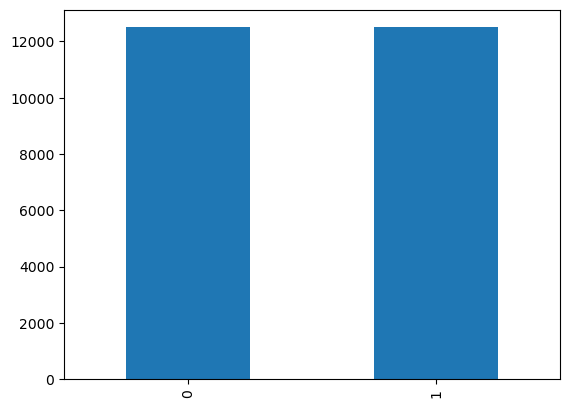

In [10]:
# Histogram of labels
training_df['label'].value_counts().plot.bar()

We can see from this histogram that we have 25,000 images in the training data set, with half being images of cats and half of dogs. We also have 12,500 test images. Next we'll preview some random images from the training data set (which are stored as JPEGs).

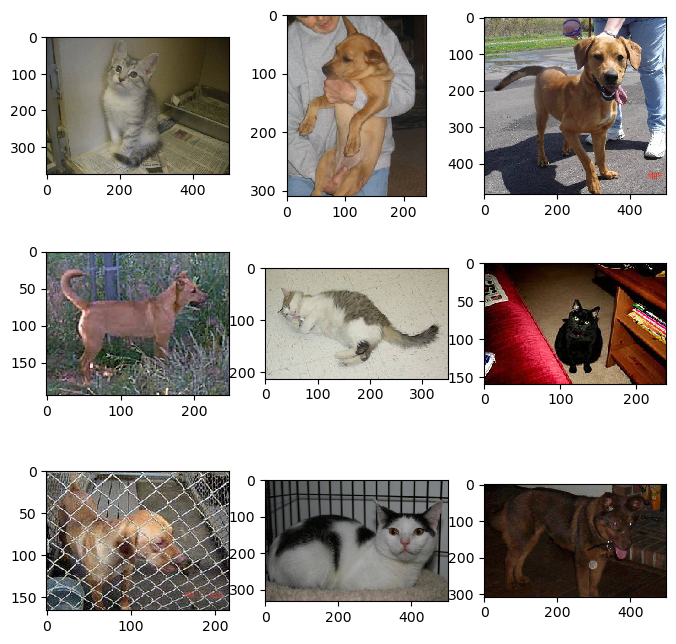

In [11]:
# Preview some images
tmp, ax = plt.subplots(3,3,figsize=(8,8))
ax = ax.flatten()
for a in ax:
    example = random.choice(filenames)
    image = load_img("/kaggle/working/train/"+example)
    a.imshow(image, interpolation='none')
plt.show()

We can see from the above samples that the images are sometimes different sizes, so we'll adjust that next so that all images are of size (128,128). Also, we'll rescale the data by 1/255 so that it is normalized. The data will be randomly flipped horizontally and rotated to increase diversity of the input data set to train against. The images will be imported using an ImageDataGenerator from keras. Since we will use a generator with class_mode = categorical, we need to convert the labels to strings. The generator will perform one-hot encoding for our model. This data set does not require correlation analysis, does not seem to have any outliers, or any missing data, so we'll plan on using all of the data. We'll split the 25,000 training images into train and validate, so we can check the model before we run it against the test data set.

In [12]:
# Convert label to string
training_df["label"] = training_df["label"].replace({0: 'cat', 1: 'dog'})

# Split training data into train and validate
train_data, valid_data = train_test_split(training_df, test_size=0.20, random_state=1)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

# Import training data using keras
training_data = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    horizontal_flip=True)
training_generator = training_data.flow_from_dataframe(
    train_data, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=20)
validate_data = ImageDataGenerator(rescale=1./255)
validate_generator = validate_data.flow_from_dataframe(
    valid_data, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=20)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [13]:
# Import test data using keras
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/kaggle/working/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=20,
    shuffle=False)

Found 12500 validated image filenames.


# Step 4: Model Architecture, Analysis, and Results
We will start this classification problem with a basic Convolutional Neural Network, a classic deep learning model. This model will start with a number of basic 2D convolutional layers, dense and flatten layers, and max pooling layers. The max pooling layers take the maximum of a subset of data to reduce the size and can help extract sharp and smooth features. We will use relu activation functions for the 2D convolutional layers to address the vanishing gradient problem. The output layer will include a softmax activation function so that the output values are scaled into probabilities for the 2 classes: dog and cat. Categorical crossentropy loss is used because the true values were one hot encoded with our ImageDataGenerator. RMSProp (root mean squared propagation) is the first optimizer chosen, which is an extension of gradient descent.

In [22]:
# Create CNN - Model 1
model_one = Sequential()
model_one.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_one.add(MaxPooling2D(pool_size=(2, 2)))
model_one.add(Conv2D(64, (3, 3), activation='relu'))
model_one.add(MaxPooling2D(pool_size=(2, 2)))
model_one.add(Conv2D(128, (3, 3), activation='relu'))
model_one.add(MaxPooling2D(pool_size=(2, 2)))
model_one.add(Flatten())
model_one.add(Dense(512, activation='relu'))
model_one.add(Dense(2, activation='softmax'))
model_one.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_one.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)     

In [23]:
# Train CNN model one - 20 epochs
history = model_one.fit(
    training_generator, 
    epochs = 20,
    validation_data = validate_generator,
    validation_steps = len(validate_generator)/20,
    steps_per_epoch = len(training_generator)/20,
)

Epoch 1/20
50/50 [==============================] - 26s 509ms/step - loss: 1.1642 - accuracy: 0.5100 - val_loss: 0.6880 - val_accuracy: 0.5538
Epoch 2/20
50/50 [==============================] - 25s 494ms/step - loss: 0.6977 - accuracy: 0.5730 - val_loss: 0.6760 - val_accuracy: 0.5538
Epoch 3/20
50/50 [==============================] - 25s 499ms/step - loss: 0.6887 - accuracy: 0.6150 - val_loss: 0.6662 - val_accuracy: 0.5385
Epoch 4/20
50/50 [==============================] - 26s 511ms/step - loss: 0.6694 - accuracy: 0.6280 - val_loss: 0.6317 - val_accuracy: 0.6808
Epoch 5/20
50/50 [==============================] - 25s 505ms/step - loss: 0.6427 - accuracy: 0.6470 - val_loss: 0.6181 - val_accuracy: 0.6115
Epoch 6/20
50/50 [==============================] - 26s 515ms/step - loss: 0.6124 - accuracy: 0.6670 - val_loss: 0.6878 - val_accuracy: 0.6192
Epoch 7/20
50/50 [==============================] - 25s 495ms/step - loss: 0.6066 - accuracy: 0.6750 - val_loss: 0.5221 - val_accuracy: 0.7346

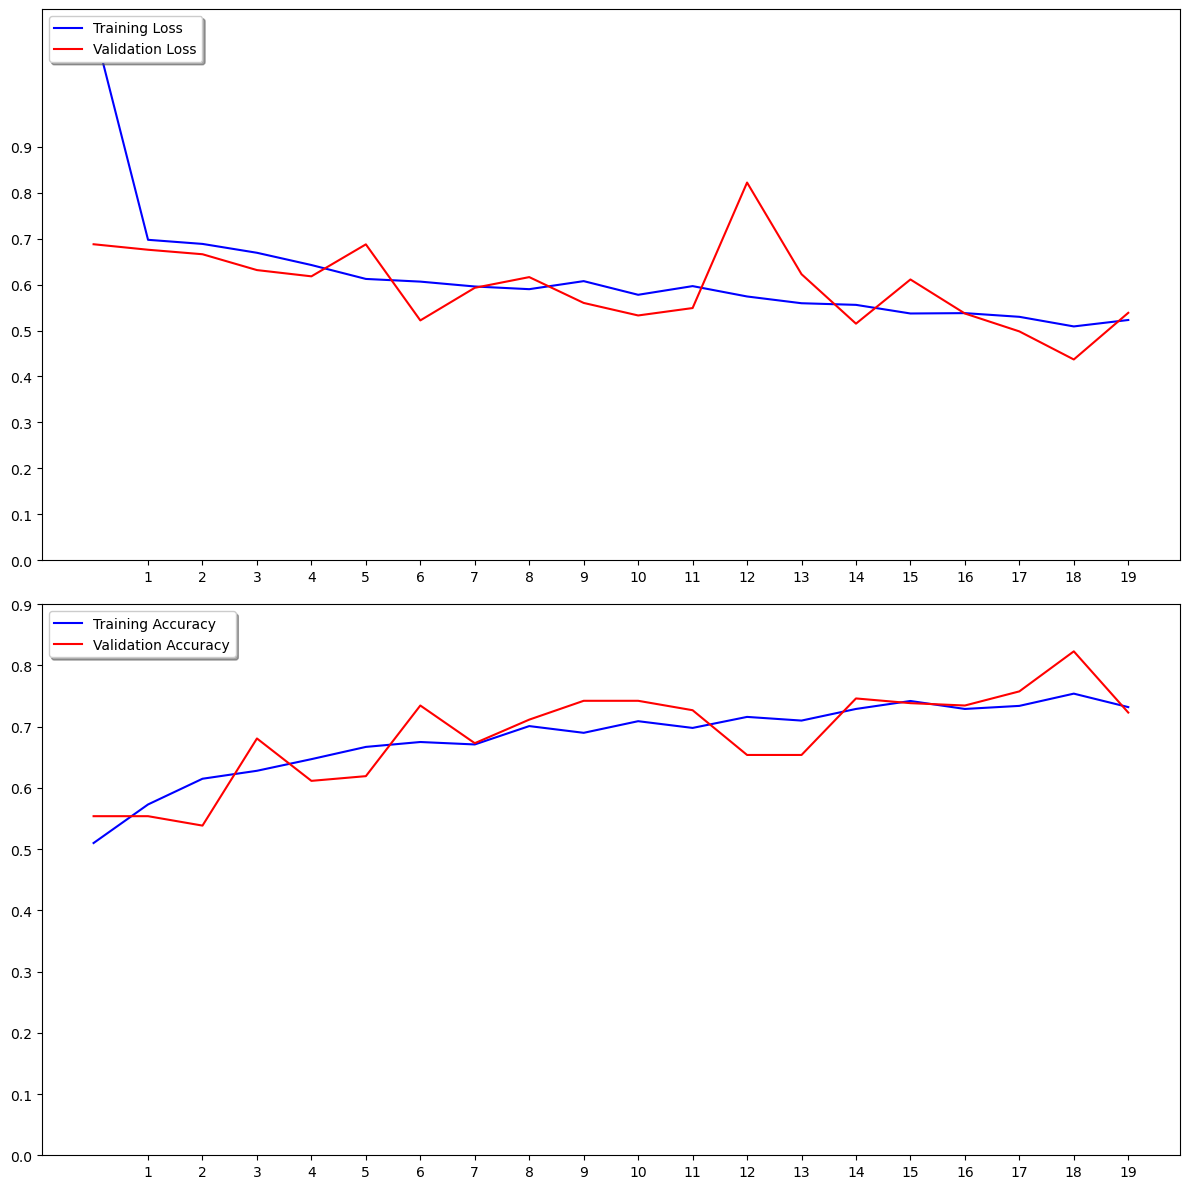

In [33]:
# Plot loss vs epoch
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation Loss")
ax1.set_xticks(np.arange(1, 20, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
legend = ax1.legend(loc='upper left', shadow=True)

# Plot accuracy vs epoch
ax2.plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
ax2.set_xticks(np.arange(1, 20, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))
legend = ax2.legend(loc='upper left', shadow=True)
plt.tight_layout()
plt.show()

In investigating the accuracy and losses, for the training and validation data sets, we did fairly well but could maybe do better. We got fairly close to 70-80% accuracy on the training and validation data. Our loss is around 0.5. The validation data set loss and accuracy were still pretty noisy. We don't think any overfitting is going on, because we did not get significantly worse over time, but it is worth adding in some other layers to make sure. To address this, in our next model we will also include multiple dropout and batch normalization layers.

In [37]:
# Create CNN - Model 2
model_two = Sequential()
model_two.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_two.add(BatchNormalization())
model_two.add(MaxPooling2D(pool_size=(2, 2)))
model_two.add(Dropout(0.3))
model_two.add(Conv2D(64, (3, 3), activation='relu'))
model_two.add(BatchNormalization())
model_two.add(MaxPooling2D(pool_size=(2, 2)))
model_two.add(Dropout(0.3))
model_two.add(Conv2D(128, (3, 3), activation='relu'))
model_two.add(BatchNormalization())
model_two.add(MaxPooling2D(pool_size=(2, 2)))
model_two.add(Dropout(0.3))
model_two.add(Flatten())
model_two.add(Dense(512, activation='relu'))
model_two.add(BatchNormalization())
model_two.add(Dropout(0.3))
model_two.add(Dense(2, activation='softmax'))
model_two.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_two.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 61, 61, 64)      

In [38]:
# Train CNN model two
history = model_two.fit(
    training_generator, 
    epochs = 20,
    validation_data = validate_generator,
    validation_steps = len(validate_generator)/20,
    steps_per_epoch = len(training_generator)/20,
)

Epoch 1/20
50/50 [==============================] - 31s 598ms/step - loss: 1.3089 - accuracy: 0.5820 - val_loss: 0.9615 - val_accuracy: 0.5731
Epoch 2/20
50/50 [==============================] - 30s 594ms/step - loss: 0.8640 - accuracy: 0.6070 - val_loss: 2.8281 - val_accuracy: 0.5154
Epoch 3/20
50/50 [==============================] - 30s 592ms/step - loss: 0.9287 - accuracy: 0.5910 - val_loss: 1.1170 - val_accuracy: 0.4923
Epoch 4/20
50/50 [==============================] - 30s 592ms/step - loss: 0.7761 - accuracy: 0.6100 - val_loss: 0.8344 - val_accuracy: 0.5192
Epoch 5/20
50/50 [==============================] - 30s 594ms/step - loss: 0.7457 - accuracy: 0.5970 - val_loss: 1.0893 - val_accuracy: 0.5423
Epoch 6/20
50/50 [==============================] - 30s 593ms/step - loss: 0.7127 - accuracy: 0.6320 - val_loss: 0.9277 - val_accuracy: 0.5192
Epoch 7/20
50/50 [==============================] - 30s 593ms/step - loss: 0.6816 - accuracy: 0.6560 - val_loss: 0.6883 - val_accuracy: 0.6269

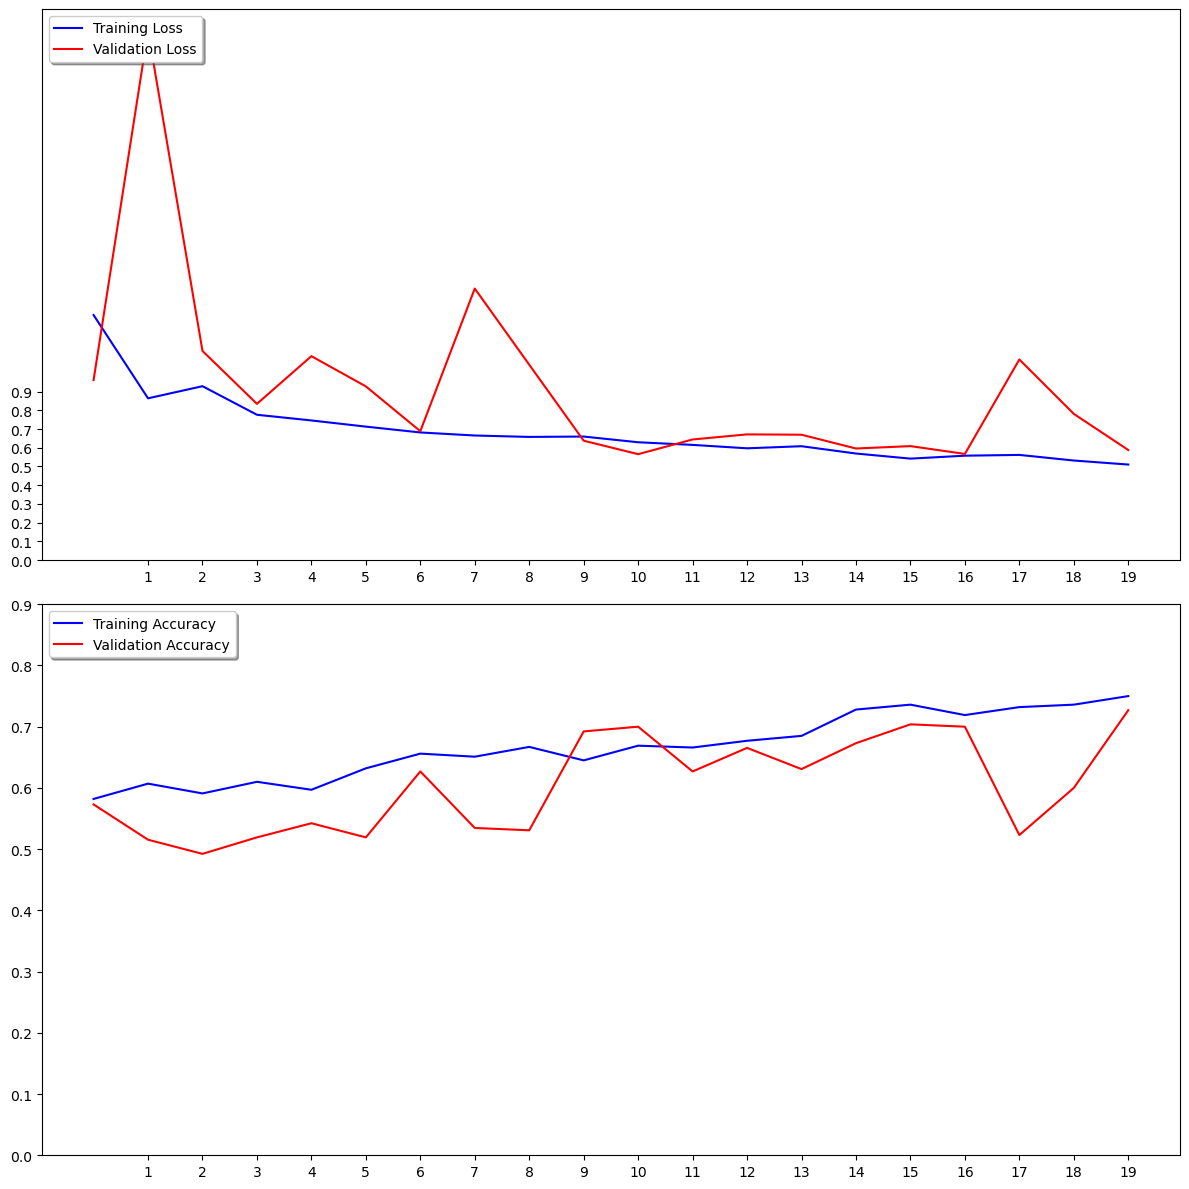

In [39]:
# Plot loss vs epoch
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation Loss")
ax1.set_xticks(np.arange(1, 20, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
legend = ax1.legend(loc='upper left', shadow=True)

# Plot accuracy vs epoch
ax2.plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
ax2.set_xticks(np.arange(1, 20, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))
legend = ax2.legend(loc='upper left', shadow=True)
plt.tight_layout()
plt.show()

In inspecting our loss and accuracy curves, this model actually seem to do worse than our simpler model! Batch normalization and dropout layers can help in some situations, but this implementation actually turned out to make things worse. This just makes the case that sometimes simpler models might be better for your problem then more complicted ones. In the next model, we'll go back to our first model but only add a single dropout layer. We'll also add in a learning rate reduction callback, which will decrease the learning rate when the accuracy does not increase for 2 steps. We'll try going out to 30 epochs as well, since it didn't seem like we were overfitting much originally.

In [46]:
# Create CNN - Model 3
model_three = Sequential()
model_three.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_three.add(MaxPooling2D(pool_size=(2, 2)))
model_three.add(Conv2D(64, (3, 3), activation='relu'))
model_three.add(MaxPooling2D(pool_size=(2, 2)))
model_three.add(Conv2D(128, (3, 3), activation='relu'))
model_three.add(MaxPooling2D(pool_size=(2, 2)))
model_three.add(Flatten())
model_three.add(Dense(512, activation='relu'))
model_three.add(Dropout(0.3))
model_three.add(Dense(2, activation='softmax'))
model_three.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_three.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 14, 14, 128)     

In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [48]:
# Train CNN model three
history = model_three.fit(
    training_generator, 
    epochs = 30,
    validation_data = validate_generator,
    validation_steps = len(validate_generator)/20,
    steps_per_epoch = len(training_generator)/20,
    callbacks = learning_rate_reduction,
)

Epoch 1/30
50/50 [==============================] - 31s 591ms/step - loss: 1.2029 - accuracy: 0.5360 - val_loss: 0.6789 - val_accuracy: 0.5269 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 27s 535ms/step - loss: 0.6992 - accuracy: 0.5450 - val_loss: 0.6702 - val_accuracy: 0.6269 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 26s 527ms/step - loss: 0.6888 - accuracy: 0.5730 - val_loss: 0.6461 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 26s 521ms/step - loss: 0.6974 - accuracy: 0.6080 - val_loss: 0.6225 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 27s 547ms/step - loss: 0.6562 - accuracy: 0.6470 - val_loss: 0.6990 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 29s 567ms/step - loss: 0.6482 - accuracy: 0.6440 - val_loss: 0.5826 - val_accuracy: 0.6846 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 29s 568ms/st

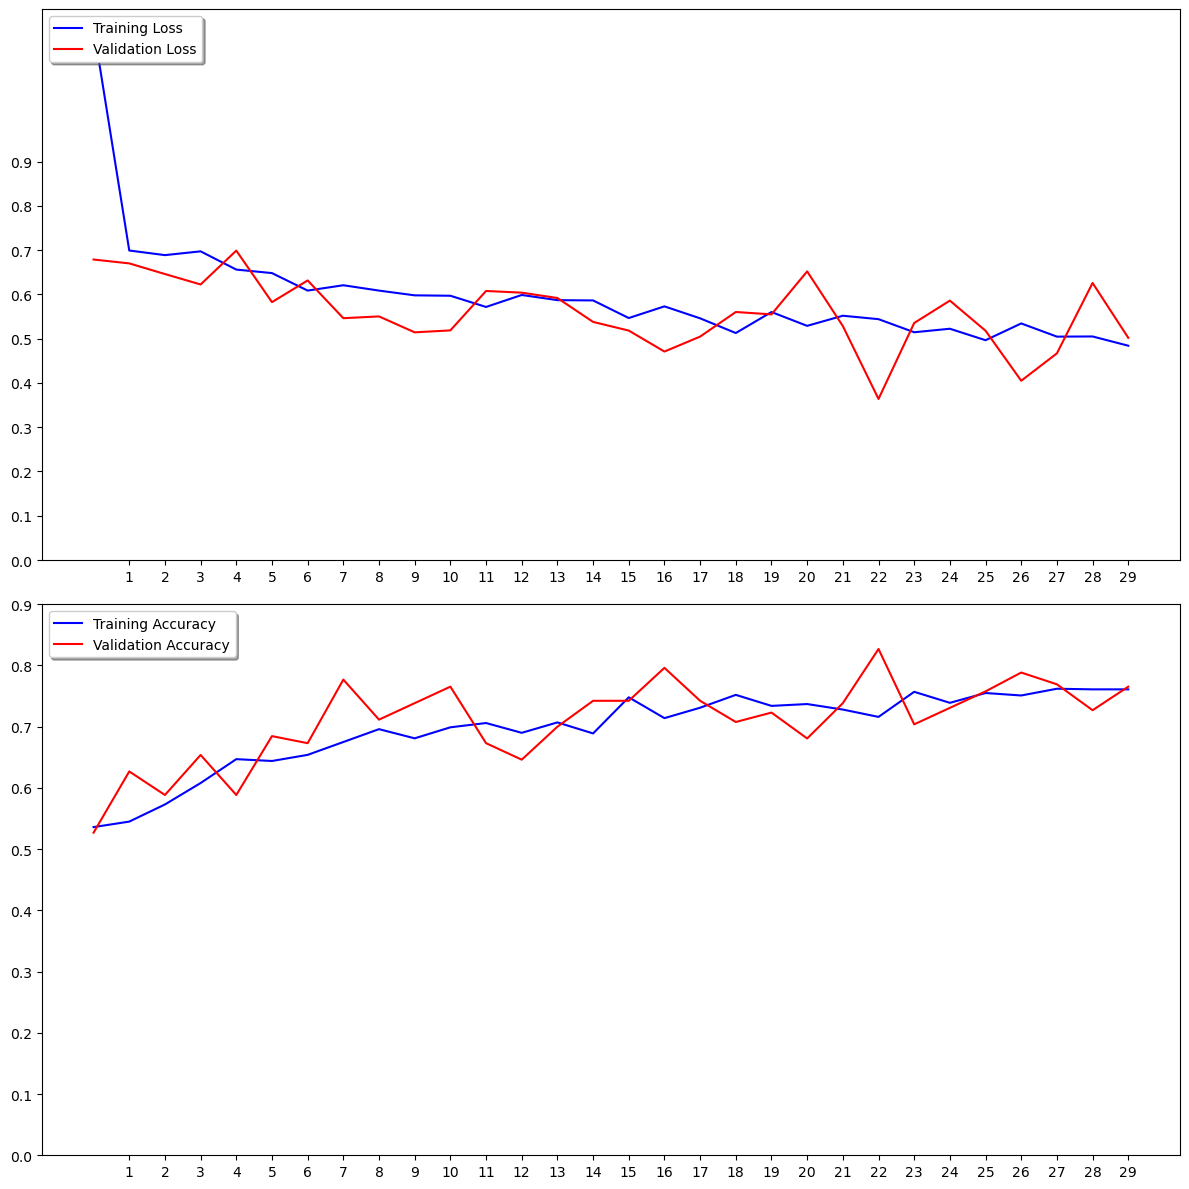

In [50]:
# Plot loss vs epoch
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation Loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
legend = ax1.legend(loc='upper left', shadow=True)

# Plot accuracy vs epoch
ax2.plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))
legend = ax2.legend(loc='upper left', shadow=True)
plt.tight_layout()
plt.show()

This model has done a bit better than the first model, which is great. We have gotten very close to our goal of 80% accuracy on the validation data. Turns out, a simpler model worked best with some minor adjustments like one dropout layer and a learning rate reducer. Now, let's predict the labels for the test data set, and view some examples of the results.

6250/6250 [==============================] - 71s 11ms/step


<AxesSubplot:>

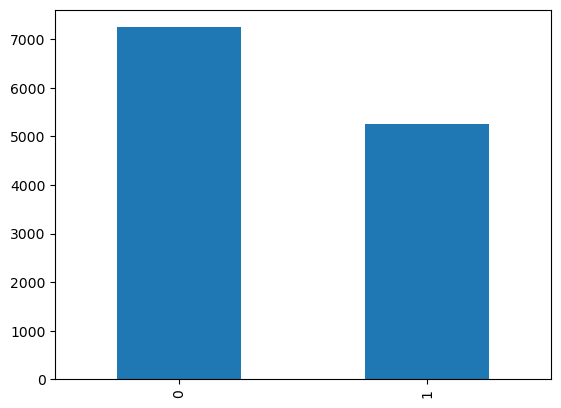

In [58]:
# Predict classification for test data
predictions = model_three.predict(test_generator, steps=np.ceil(125000/20))
test_df['label'] = np.argmax(predictions, axis=-1)
label_map = dict((v,k) for k,v in training_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)
test_df['label_value'] = test_df['label'].replace({ 'dog': 1, 'cat': 0 })
test_df['label_value'].value_counts().plot.bar()

It looks like we predicted more cats than dogs in the test data set. Unfortunately, we don't have true labels for the test data set or an open kaggle competition to submit to see what our score is, but we can visually inspect a few images and see if the labels make sense.

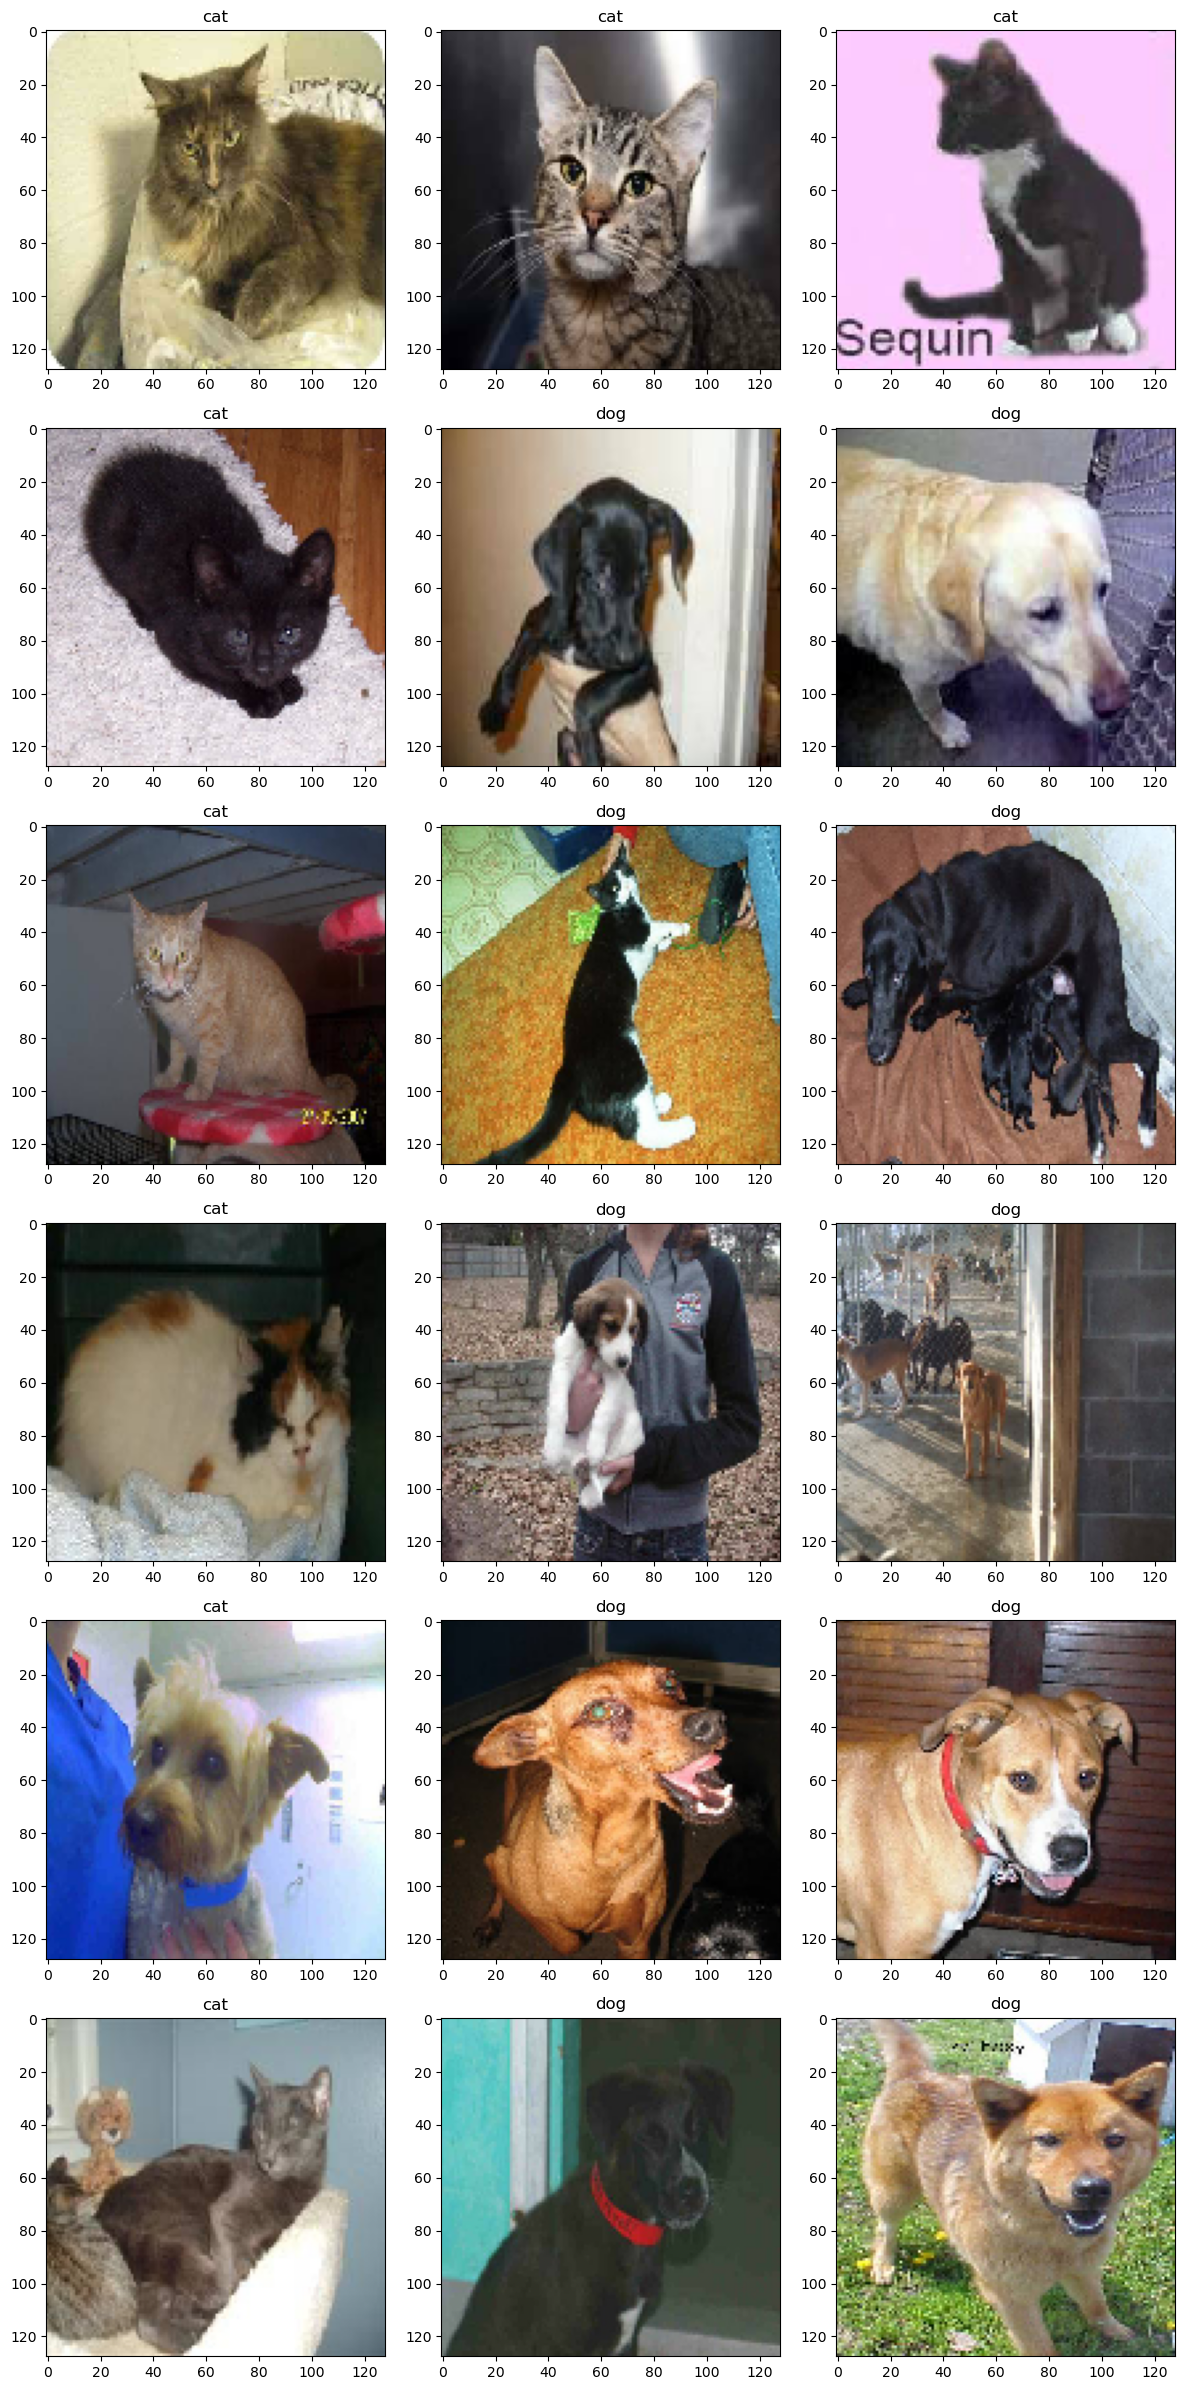

In [60]:
# Visualize results
examples = test_df.head(18)
plt.figure(figsize=(12, 24))
for index, row in examples.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img("/kaggle/working/test1/"+filename, target_size=(128,128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.title(category)
plt.tight_layout()
plt.show()

Wow, we actually did pretty good! Of the 18 images we just previewed, it looks like we only got 2 wrong. That doesn't seem too bad, and more or less matches what we would have predicted based on our validation data performance.

# Conclusion
First, we started with a fairly large data set of dog and cat images from Microsoft Research, which were provided by a previous kaggle competition. We had 25,000 training images with labels, and 12,500 test data images without labels. These images were various sizes, so we ended up downsizing all of them to 128 x 128 RGB images so that our machine learning model could have a constant input size. Our challenge was to predict which images contained cats and which contained dogs.

We decided to use a convolutional neural network to solve this classic classification problem. To set this up, we used keras and tensorflow to perform one hot encoding on the data, as well as randomly flip and rotate the images to provide some diversification to our data set. Our initial CNN was fairly simple, with a number of 2D convolutional layers, and common activation functions. This model did fairly well against the training and validation data sets (split into 80/20 from the original training set), but we decided to try a more complex model next.

The complex model included a number of dropout and batch normalization layers. This did not do as well as we had hoped, and we learned a valuable lesson that a simpler model might actually be best depending on the input data and problem. We went back to the simpler model and added a single dropout layer, a few more epochs, and a learning rate reducer. This model did very well against the validation and training data sets, and did not seem to overfit much. We approached our goal of 80% accuracy on the validation data.

When we tested this model out on some example test data, we did pretty well, as we expected from the training and validation data. The real question is, is 80% accuracy good enough? It probably is for this kind of classification problem, but maybe not so much for more critical issues, such as identifying cancer or brain tumors in MRI scans.

There are a number of things we could try out in the future to improve our model. This includes additional optimizers, like adam, or diversifying/augenting our data even more. We also may have been able to get away with keeping our original images a little larger, to better pull out advanced features. This will increase our training time, but can be reduced with more advanced resources, such as TPUs. I hope you enjoyed my final project!